In [58]:
import keras
import tensorflow as tf
import keras.layers as layers
import keras.activations as activations
import numpy as np

import pylab as pl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal 
from scipy.io import wavfile

import sounddevice as sd

# 1. Mise en place des données tests

/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


172.8


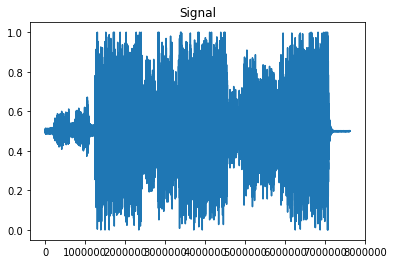

In [59]:
rate, sls = wavfile.read('Sls.wav')
sls = sls/np.max(sls)

N = len(sls)
print(N/rate)

time = np.arange(N)/rate

plt.plot(sls)
plt.title('Signal')
plt.show()

sd.play(sls/np.max(sls),rate)

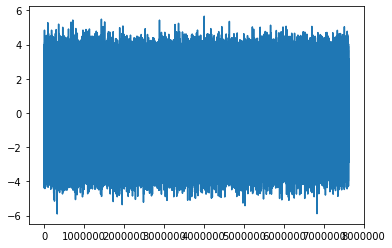

In [60]:
Ns = N
sigma_carre = 1.2

#compute gaussian signal
Samples = np.power(1.2,0.5)*np.random.randn(Ns)
abs = np.arange(Ns)
pl.plot(abs,Samples)
pl.show()

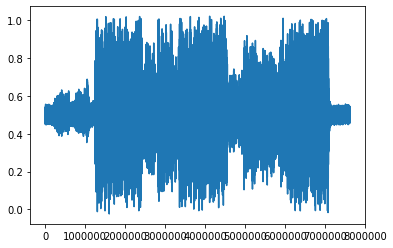

In [61]:
slsn = sls + Samples/90

pl.plot(slsn)

pl.show()

#sd.play(slsn[3200000:3200000+3200000]/np.max(sls),rate)

In [62]:
def make_extrait(x,fs):
    data = np.zeros((1,fs*2))
    i=0
    data = [x[i:i+fs*2]]
    i+=fs
    while(i+fs*2<len(x)):

        data = np.concatenate((data,[x[i:i+fs*2]]),0)
        i += fs
    
    return data






In [69]:
print(np.shape(sls))

ex_sls = make_extrait(sls,rate)
ex_slsn = make_extrait(slsn,rate)

print(np.shape(ex_sls))
print(np.shape(ex_slsn)) 

f,t, stft_c = scipy.signal.stft(ex_sls[0],rate, 'hann',512,128)

f,t, stft_n = scipy.signal.stft(ex_sls[0],rate, 'hann',512,128)

for i in range(1,np.shape(ex_sls)[0]):
    f,t, a = scipy.signal.stft(ex_sls[i],rate, 'hann',512,128)
    f,t, b = scipy.signal.stft(ex_sls[i],rate, 'hann',512,128)

    stft_c = np.concatenate((stft_c,a),axis=1)
    stft_n = np.concatenate((stft_n,b),axis=1)


print(np.shape(stft_c))
print(np.shape(stft_n)) 







(7620480,)
(171, 88200)
(171, 88200)
(257, 39501)
(257, 39501)


In [80]:
print(np.shape(ex_sls))

A = tf.signal.stft(ex_sls[0],frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)

print(np.shape(A))


(171, 88200)
(686, 257)


Nous avons nos deux signaux de base, l'un bruité slsn, et l'autre propre sls.

# 2. Écriture des loss function

In [8]:
a = tf.constant([1,2])
b = tf.constant([3,2])

tf.tensordot(a,b,1).numpy()

7

In [9]:
def L_wav(y_true,y_pred):

    return -tf.divide(tf.tensordot(y_pred,y_true,1),tf.multiply(tf.norm(y_pred),tf.norm(y_true)))

def L_spec(y_true,y_pred):

    return tf.pow(tf.norm(tf.pow(tf.norm(y_true),0.3)-tf.pow(tf.norm(y_pred),0.3)),2)


# 3. Depthwise-separable convolution

In [40]:
class DepthwiseSeparableConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
        self.kernel = kernel_size
      
        self.conv1d_1 = layers.Conv1D(out_channels, kernel_size, input_shape =(None, in_channels), padding='same' ,groups = in_channels, strides = stride)
        
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1d_2 = tf.keras.layers.Conv1D(out_channels , 1)

        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)


    def call (self, x):

        x = self.conv1d_1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        print(np.shape(x))

        #pad = np.zeros((np.shape(x)[0],self.kernel//2,np.shape(x)[2]))
        #pad_x = np.concatenate((pad,x.numpy(),pad),axis=1)
        y = self.conv1d_2(x)
        y = self.norm2(y)
        y = self.relu2(y)

        return y



In [153]:
class DepthwiseSeparableConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
 
        self.conv1d_ptwise = layers.Conv1D(in_channels,1)

        self.norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1d_dpwise = layers.DepthwiseConv1D(kernel_size,strides=stride,padding = 'same',depth_multiplier=int(out_channels//in_channels),activation=activations.relu)

        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)


    def call (self, x):
        #print('dp',np.shape(x))
        x = self.conv1d_ptwise(x)

        x = self.norm1(x)
        x = self.relu1(x)

        #print('dp2',np.shape(x))

        y = self.conv1d_dpwise(x)
       # print('dp3',np.shape(y))

        y = self.norm2(y)
        y = self.relu2(y)

        return y


In [148]:
class FirstBlock_DSConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
 
        

        self.conv1d = layers.Conv1D(out_channels,kernel_size,strides=stride,padding = 'same',)

        self.norm = tf.keras.layers.BatchNormalization()
        self.relu = layers.Activation(activations.relu)


    def call (self, x):
        #print('dp',np.shape(x))
        
        y = self.conv1d(x)
        #print('dp3',np.shape(y))

        y = self.norm(y)
        y = self.relu(y)

        return y

In [102]:
model = DepthwiseSeparableConv1d(1,1,5,1)

x = tf.math.abs(tf.constant([stft_n]))
y = tf.math.abs(tf.constant([stft_c]))
print(np.shape(x))
x=tf.transpose(x, perm=[2,1,0])
y=tf.transpose(y, perm=[2,1,0])
print(np.shape(x))

model.compile(loss=L_spec,optimizer='adam')
model.fit(x,y, verbose=2, epochs=1000,batch_size=1000,shuffle=True)

(1, 257, 39501)
(39501, 257, 1)
Epoch 1/1000
dp (None, 257, 1)
dp2 (None, 257, 1)
dp3 (None, 257, 1)
dp (None, 257, 1)
dp2 (None, 257, 1)
dp3 (None, 257, 1)


KeyboardInterrupt: 

In [ ]:
#STFT des signaux et phase
t, f, a = scipy.signal.stft(slsn,rate, 'hann',512,128)
t, f, b = scipy.signal.stft(sls,rate, 'hann',512,128)
phase = np.angle(b)

#mise en forme pour rentrer dans le module
#a est bruité
at = tf.math.abs(tf.constant([a]))
at = tf.transpose(at, perm=[2,1,0])

#b est clean
bt = tf.math.abs(tf.constant([b]))
bt = tf.transpose(bt, perm=[2,1,0])

print(np.shape(at))
print(np.shape(phase))

m = model(at)
ad = tf.transpose(m, perm=[2,1,0])
ar = ad[0] * np.exp(phase*1j)
print(np.shape(ar))



(19846, 257, 1)
(257, 19846)
(19846, 257, 1)
(19846, 257, 1)
(257, 19846)


/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6577: ComplexWarning: Casting complex values to real discards the imaginary part
  _ctx, "Mul", name, x, y)


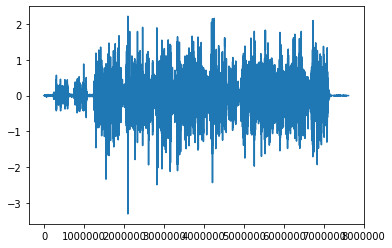

In [ ]:
xrec = sp.signal.istft(ar, rate, 'hann',512,128)

rec = xrec[1]
pl.plot(rec)
pl.show()
sd.play(rec,rate)

# 3. Modèle Encoder qu'on fait évoluer

In [157]:
class Encoder_TRU_Net(tf.keras.Model):

    def __init__(self):


        super().__init__()

        



        self.cnn_1d_block1 = FirstBlock_DSConv1d(1,64,5,2)
        self.cnn_1d_block2 = DepthwiseSeparableConv1d(64,128,3,1)
        self.cnn_1d_block3 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block4 = DepthwiseSeparableConv1d(128,128,3,1)
        self.cnn_1d_block5 = DepthwiseSeparableConv1d(128,128,5,2)
        self.cnn_1d_block6 = DepthwiseSeparableConv1d(128,128,3,2)
        
        self.faux_layer = layers.Conv1D(256,16,)

        self.norm = tf.keras.layers.BatchNormalization()


    def call (self, x):

        x = self.norm(x)
        
        x = tf.signal.stft(x,frame_length=512,frame_step=128,window_fn=tf.signal.hann_window)
       # print(np.shape(x))
        phase = tf.math.angle(x[:,:-1])
        #x = tf.expand_dims(tf.abs(x[:,:-1]),axis=0)
        x = tf.abs(x[:,:-1])
        #À REGARDER DE PLUS PRES LE STFT
        x = tf.transpose(x, perm=[1,2,0])
        #print(np.shape(x))

        x = self.cnn_1d_block1(x)
        #print(np.shape(x))
        x = self.cnn_1d_block2(x)
        #print(np.shape(x))
        x = self.cnn_1d_block3(x)
        #print(np.shape(x))
        x = self.cnn_1d_block4(x)
        #print(np.shape(x))
        x = self.cnn_1d_block5(x)
        #print(np.shape(x))
        x = self.cnn_1d_block6(x)
        #print(np.shape(x))
        x = self.faux_layer(x)
        #print(np.shape(x))
        x = tf.transpose(x, perm=[1,0,2])
        #print(np.shape(x))
        m = tf.cast(x[0], tf.complex128)
        t = tf.cast(phase, tf.complex128)
        p = tf.math.exp(tf.multiply(tf.constant(1j),t))
        y = tf.multiply(m,p)
        y = tf.signal.inverse_stft(y,512,128,window_fn=tf.signal.hann_window)
        return y

In [158]:
encoder = Encoder_TRU_Net()
print(np.shape(ex_slsn))
y=encoder(ex_slsn[0])
print(np.shape(y))

(171, 88200)


InvalidArgumentError: Exception encountered when calling layer "encoder_tru__net_34" (type Encoder_TRU_Net).

transpose expects a vector of size 2. But input(1) is a vector of size 3 [Op:Transpose]

Call arguments received:
  • x=tf.Tensor(shape=(88200,), dtype=float32)

In [151]:

encoder = Encoder_TRU_Net()
encoder.compile(loss=L_wav,optimizer='adam')
encoder.fit(ex_slsn,ex_sls, verbose=2, epochs=100,batch_size=10,shuffle=True)
y = encoder(ex_sls[0])

print(np.shape(y))

Epoch 1/100
(None, 686, 257)


ValueError: in user code:

    File "/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/thibautvacek/opt/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "encoder_tru__net_30" (type Encoder_TRU_Net).
    
    in user code:
    
        File "<ipython-input-144-bce38d373f2e>", line 33, in call  *
            x = tf.transpose(x, perm=[1,2,0])
    
        ValueError: Dimension must be 4 but is 3 for '{{node encoder_tru__net_30/transpose}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](encoder_tru__net_30/ExpandDims, encoder_tru__net_30/transpose/perm)' with input shapes: [1,?,685,257], [3].
    
    
    Call arguments received:
      • x=tf.Tensor(shape=(None, 88200), dtype=float32)
